In [6]:
import pandas as pd
import numpy as np
import datetime as dt
import glob
import json

In [2]:
# Tables

In [7]:
query_return_rate = """
SELECT
DATE_FORMAT(t.Conv_Date, "%Y-%m") AS "YearMonth",
COUNT(Conv_ID) AS "Total_Orders",
COUNT(CASE WHEN t.Customer_Type = "Returning" THEN Conv_ID END) AS "Returning_Orders",
COUNT(CASE WHEN t.Customer_Type = "Returning" THEN Conv_ID END)/COUNT(Conv_ID)*100 AS "Repurchase Rate"
FROM
(
SELECT
alo.Hashed_Email,
alo.Conv_Date,
alo.Conv_ID,
CASE
WHEN alo.Conv_Date = first_orders.first_date THEN "New"
ELSE "Returning"
END AS "Customer_Type"
FROM
api_lightspeed.api_lightspeed_orders alo
JOIN (
SELECT
Hashed_Email,
MIN(Conv_Date) AS "first_date"
FROM
api_lightspeed.api_lightspeed_orders alo
WHERE
Account = "WOOOF"
AND Status != "cancelled"
GROUP BY
1) AS first_orders ON
first_orders.Hashed_Email = alo.Hashed_Email
WHERE
Account = "WOOOF"
AND Status != "cancelled") AS t
GROUP BY
1;
"""

In [8]:
query_lightspeed = 'SELECT * FROM api_lightspeed.api_lightspeed_orders alo WHERE Account = "WOOOF" AND Status != "cancelled"'

In [9]:
import mysql.connector
from mysql.connector import Error

try:
    connection = mysql.connector.connect(host='attribution-system-fsg-new.cob86lv75rzo.eu-west-1.rds.amazonaws.com',
                                         database='api_lightspeed',
                                         user='fsg',
                                         password='Attribution3.0')

    if connection.is_connected():
        db_Info = connection.get_server_info()
        print("Connected to MySQL Server version ", db_Info)
        cursor = connection.cursor()
        cursor.execute("select database();")
        record = cursor.fetchone()
        print("Your connected to database: ", record)
        #df_ls = pd.read_sql(query_lightspeed,con=connection)
        df_r = pd.read_sql(query_return_rate, con=connection)

except Error as e:
    print("Error while connecting to MySQL", e)
finally:
    if (connection.is_connected()):
        cursor.close()
        connection.close()
        print("MySQL connection is closed")

Connected to MySQL Server version  8.0.16
Your connected to database:  ('api_lightspeed',)
MySQL connection is closed


In [4]:
#df = df_ls.copy()

In [ ]:
df.head()

In [7]:
df.columns

Index(['Account', 'Market', 'Conv_Date', 'Conv_ID', 'Conv_Number', 'Revenue',
       'Revenue_excl_VAT', 'Customer_ID', 'Hashed_Email', 'Shipping_Country',
       'Shipping_Amount', 'Shipping_Amount_excl_VAT', 'Payment_Type',
       'Status'],
      dtype='object')

In [20]:
df.Market.unique()

array(['DE'], dtype=object)

In [19]:
df.Payment_Type.value_counts()

Pay.nl - PayPal                     15406
Payment Amazon                       7931
Klarna DE - In 14 Tagen bezahlen     4712
Pay.nl - Banküberweisung             1949
Pay.nl - Sofortbanking               1646
Pay.nl - Visa Mastercard              724
Klarna DE - Klarna Rechnung.          622
Pay.nl - Giropay                      239
Customer choice                        70
Name: Payment_Type, dtype: int64

In [17]:
df.Status.value_counts()

completed_shipped               29239
processing_awaiting_shipment     2337
processing_awaiting_payment      1723
Name: Status, dtype: int64

## Returning Rate

In [11]:
df1 = df_r.copy()

In [12]:
df1.head()

,YearMonth,Total_Orders,Returning_Orders,Repurchase Rate
0,2017-11,501,17,3.3932
1,2017-12,802,109,13.5910
2,2018-01,1000,367,36.7000
3,2018-02,886,450,50.7901
4,2018-03,963,556,57.7362


In [13]:
df1.shape

(21, 4)

In [14]:
df_ls = pd.read_csv('./Data/orders-export-2021-03-16-16-13-22.csv', sep=';', decimal=',')

C:\Users\Angela\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (26,34) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [15]:
df_ls.shape

(81438, 61)

In [16]:
df_ls.columns

Index(['Order_ID', 'Order', 'Invoices', 'Credit_notes', 'Added', 'Status',
       'Custom_status', 'Payment', 'Shipping', 'Price_total', 'Price_total_ex',
       'Price_vat', 'Price_cost', 'Price_shipping', 'Weight', 'Volume',
       'Colli', 'Company', 'Vat', 'Firstname', 'Lastname', 'Phone', 'Mobile',
       'E-mail', 'Attn', 'Streetname', 'Second_address_line', 'Number',
       'Extension', 'Zipcode', 'City', 'Region', 'Country', 'Invoice_street',
       'Invoice_street_2', 'Invoice_housenumber', 'Invoice_housenumber_ext',
       'Invoice_zipcode', 'Invoice_city', 'Invoice_region', 'Invoice_country',
       'Quantity', 'Product_price', 'Product_price_cost', 'Product_weight',
       'Product_volume', 'Product_colli', 'Product_supplier', 'Product_brand',
       'Product_title', 'Product_variant', 'Product_article_code',
       'Product_EAN', 'Product_SKU', 'Discount_code', 'Discount_price',
       'Customer', 'Comment', 'Memo', 'Price_payment', 'Shipping_company'],
      dtype='object

In [17]:
%run ./cohorts_pipeline_woof_v3.py

In [18]:
df_ls = df_cleaning(df_ls)

C:\Users\Angela\Documents\Python Scripts\WOOOF\cohorts_pipeline_woof_v3.py:30: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['Week'] = df['Creation_Date'].dt.week


In [19]:
df_ls.head()

,Customer_ID,Order,Order_ID,Status,Payment,ValueNOVAT,E-mail,Firstname,Lastname,Product_title,Creation_Date,First_Order,First_Order_YM,Creation_Date_YM,Customer_Type,Payment_Type,Year,Week,Year_Week
0,46400897,DE_ORD00031,58005182,"Paid, shipped",Pay.nl - Banküberweisung,23.78,sjaak@blids.nl,Yvonne,Zermin,WOOOF Regular,2017-11-17,2017-11-17,2017-11,2017-11,New,Webshop,2017,46,2017-46
1,46544999,DE_ORD00032,58314515,"Paid, shipped",Klarna DE - Klarna Rechnung.,24.71,yzermin@gmx.de,Yvonne,Zermin,WOOOF Regular,2017-11-21,2017-11-21,2017-11,2017-11,New,Webshop,2017,47,2017-47
2,47823566,DE_ORD00034,58356140,"Paid, shipped",Pay.nl - Sofortbanking,37.33,Patrickwerb@gmx.de,Patrick,Werb,WOOOF Regular,2017-11-21,2017-11-21,2017-11,2017-11,New,Webshop,2017,47,2017-47
3,47821025,DE_ORD00035,58357271,"Paid, shipped",Pay.nl - Sofortbanking,23.78,marona1985malibu@googlemail.com,Ramona,Tinnemeier,WOOOF Regular,2017-11-21,2017-11-21,2017-11,2017-11,New,Webshop,2017,47,2017-47
4,47820044,DE_ORD00039,58428260,"Paid, shipped",Pay.nl - PayPal,76.16,bernd-jendreck@t-online.de,Bernd,Jendreck,WOOOF Regular,2017-11-22,2017-11-22,2017-11,2017-11,New,Webshop,2017,47,2017-47


In [20]:
df_ls['Creation_Date_YM'] = df_ls['Creation_Date'].apply(lambda x: x.strftime('%Y-%m'))

# Purchase Table

In [21]:
temp0 = df_ls.groupby(['E-mail','Creation_Date']).agg({'Order_ID':pd.Series.count})

In [22]:
temp0

Order_ID
E-mail                                Creation_Date          
003ppcs4s2vcj0q@marketplace.amazon.de 2019-02-19            1
                                      2019-04-10            1
                                      2019-06-04            1
009g57nc9rg76dy@marketplace.amazon.de 2019-06-30            1
                                      2019-10-21            1
...                                                       ...
zzrnnjbmtkz3fzg@marketplace.amazon.de 2020-04-01            1
zztrh549mbsn9x9@marketplace.amazon.de 2019-10-21            1
zzxb9d6c071ws6z@marketplace.amazon.de 2020-04-17            1
zzyv6pm2zm5k798@marketplace.amazon.de 2018-02-13            1
                                      2018-04-21            1

[66754 rows x 1 columns]

In [28]:
temp0 = temp0.groupby(level=0).apply(purchase_number)

In [29]:
temp0.reset_index(inplace=True)

In [30]:
temp0.drop('order_item_id',axis=1,inplace=True)

In [42]:
temp1 = df_ls.groupby('E-mail').agg({'Order_ID':pd.Series.count})
temp1

,Order_ID
E-mail,
003ppcs4s2vcj0q@marketplace.amazon.de,3
009g57nc9rg76dy@marketplace.amazon.de,10
00j89nxrhbft07k@marketplace.amazon.de,1
00jx5l3sntnj5p1@marketplace.amazon.de,1
00sk0ls66hd2c5x@marketplace.amazon.de,2
...,...
zzmgl1s1l04mzws@marketplace.amazon.de,3
zzrnnjbmtkz3fzg@marketplace.amazon.de,1
zztrh549mbsn9x9@marketplace.amazon.de,1


In [32]:
temp1.rename(columns={'order_item_id':'total_purchases'},inplace=True)

In [33]:
temp1.reset_index(inplace=True)

In [34]:
temp2 = temp0.merge(temp1, on='email',how='left')

In [35]:
temp3 = df.groupby(['email','date','category','product_type','animal_type']).agg({'order_item_id':pd.Series.count})

In [36]:
temp3.reset_index(inplace=True)

In [37]:
purchase_table = temp2.merge(temp3, on=['email','date'], how='left')

In [38]:
purchase_table.drop('order_item_id',axis=1,inplace=True)

In [39]:
purchase_table['days_between'] = purchase_table.groupby('email')['date'].diff().apply(lambda x: x.days)

In [40]:
purchase_table['days_between'].fillna(0,inplace=True)

In [41]:
purchase_table['category_type'] = purchase_table['product_type'] + "_" + purchase_table['animal_type'] 

In [42]:
purchase_table = purchase_table[~purchase_table.category.str.contains('Coupon')]

In [43]:
unstack_table = purchase_table.groupby(['email','category_type']).agg({'category':pd.Series.nunique}).unstack(1).fillna(0)

In [44]:
unstack_table.columns = unstack_table.columns.droplevel()

In [45]:
unstack_table.reset_index(inplace=True)

In [46]:
unstack_table.shape

(116129, 18)

## Time decay

In [25]:
df_ls.columns

Index(['Customer_ID', 'Order', 'Order_ID', 'Status', 'Payment', 'ValueNOVAT',
       'E-mail', 'Firstname', 'Lastname', 'Product_title', 'Creation_Date',
       'First_Order', 'First_Order_YM', 'Creation_Date_YM', 'Customer_Type',
       'Payment_Type', 'Year', 'Week', 'Year_Week'],
      dtype='object')

In [26]:
df_ls['First_Order'][:5]

0   2017-11-17
1   2017-11-21
2   2017-11-21
3   2017-11-21
4   2017-11-22
Name: First_Order, dtype: datetime64[ns]

In [27]:
td2 = df3.groupby(['E-mail','First_Order']).agg({'Creation_Date':pd.Series.count})
td2

NameError: name 'df3' is not defined

In [28]:
df3 = df_ls.sort_values(by='Creation_Date')

In [29]:
df3['DaysDiff'] = df3.groupby('E-mail')['Creation_Date'].diff().apply(lambda x: x.days).fillna(0)

In [30]:
df3.head()

,Customer_ID,Order,Order_ID,Status,Payment,ValueNOVAT,E-mail,Firstname,Lastname,Product_title,Creation_Date,First_Order,First_Order_YM,Creation_Date_YM,Customer_Type,Payment_Type,Year,Week,Year_Week,DaysDiff
0,46400897,DE_ORD00031,58005182,"Paid, shipped",Pay.nl - Banküberweisung,23.78,sjaak@blids.nl,Yvonne,Zermin,WOOOF Regular,2017-11-17,2017-11-17,2017-11,2017-11,New,Webshop,2017,46,2017-46,0.0
1,46544999,DE_ORD00032,58314515,"Paid, shipped",Klarna DE - Klarna Rechnung.,24.71,yzermin@gmx.de,Yvonne,Zermin,WOOOF Regular,2017-11-21,2017-11-21,2017-11,2017-11,New,Webshop,2017,47,2017-47,0.0
2,47823566,DE_ORD00034,58356140,"Paid, shipped",Pay.nl - Sofortbanking,37.33,Patrickwerb@gmx.de,Patrick,Werb,WOOOF Regular,2017-11-21,2017-11-21,2017-11,2017-11,New,Webshop,2017,47,2017-47,0.0
3,47821025,DE_ORD00035,58357271,"Paid, shipped",Pay.nl - Sofortbanking,23.78,marona1985malibu@googlemail.com,Ramona,Tinnemeier,WOOOF Regular,2017-11-21,2017-11-21,2017-11,2017-11,New,Webshop,2017,47,2017-47,0.0
22,47935061,DE_ORD00059,58480067,"Paid, shipped",Payment Amazon,23.81,3m6zffthzjfq5qh@marketplace.amazon.de,Martina,Schulte,WOOOF Regular,2017-11-22,2017-11-22,2017-11,2017-11,New,Amazon,2017,47,2017-47,0.0


In [31]:
df3['DaysDiff'] = df3['Creation_Date'] - df3['First_Order']
df3.head()

,Customer_ID,Order,Order_ID,Status,Payment,ValueNOVAT,E-mail,Firstname,Lastname,Product_title,Creation_Date,First_Order,First_Order_YM,Creation_Date_YM,Customer_Type,Payment_Type,Year,Week,Year_Week,DaysDiff
0,46400897,DE_ORD00031,58005182,"Paid, shipped",Pay.nl - Banküberweisung,23.78,sjaak@blids.nl,Yvonne,Zermin,WOOOF Regular,2017-11-17,2017-11-17,2017-11,2017-11,New,Webshop,2017,46,2017-46,0 days
1,46544999,DE_ORD00032,58314515,"Paid, shipped",Klarna DE - Klarna Rechnung.,24.71,yzermin@gmx.de,Yvonne,Zermin,WOOOF Regular,2017-11-21,2017-11-21,2017-11,2017-11,New,Webshop,2017,47,2017-47,0 days
2,47823566,DE_ORD00034,58356140,"Paid, shipped",Pay.nl - Sofortbanking,37.33,Patrickwerb@gmx.de,Patrick,Werb,WOOOF Regular,2017-11-21,2017-11-21,2017-11,2017-11,New,Webshop,2017,47,2017-47,0 days
3,47821025,DE_ORD00035,58357271,"Paid, shipped",Pay.nl - Sofortbanking,23.78,marona1985malibu@googlemail.com,Ramona,Tinnemeier,WOOOF Regular,2017-11-21,2017-11-21,2017-11,2017-11,New,Webshop,2017,47,2017-47,0 days
22,47935061,DE_ORD00059,58480067,"Paid, shipped",Payment Amazon,23.81,3m6zffthzjfq5qh@marketplace.amazon.de,Martina,Schulte,WOOOF Regular,2017-11-22,2017-11-22,2017-11,2017-11,New,Amazon,2017,47,2017-47,0 days


In [32]:
df3.tail()

,Customer_ID,Order,Order_ID,Status,Payment,ValueNOVAT,E-mail,Firstname,Lastname,Product_title,Creation_Date,First_Order,First_Order_YM,Creation_Date_YM,Customer_Type,Payment_Type,Year,Week,Year_Week,DaysDiff
77653,50335508,DE_ORD70646,179779698,"Paid, shipped",Pay.nl - PayPal,62.10,engelienchen@web.de,Corinna,Engel-Hieke,WOOOF Lamm & Kartoffel,2021-03-16,2017-12-20,2017-12,2021-03,Returning,Webshop,2021,11,2021-11,1182 days
77652,129977135,DE_ORD70645,179778892,"Paid, shipped",Klarna DE - In 14 Tagen bezahlen,47.62,claudia.lefarth@googlemail.com,Ruth-Claudia,Lefarth,WOOOF Welpen,2021-03-16,2021-01-08,2021-01,2021-03,Returning,Webshop,2021,11,2021-11,67 days
77651,134969741,DE_ORD70643,179778776,"Paid, shipped",Pay.nl - PayPal,NaN,info@style2trail.de,Christiane,Wildhirt,Schafsfett,2021-03-16,2021-03-16,2021-03,2021-03,New,Webshop,2021,11,2021-11,0 days
77649,134969741,DE_ORD70643,179778776,"Paid, shipped",Pay.nl - PayPal,NaN,info@style2trail.de,Christiane,Wildhirt,Schafsfett & Kurkuma Bites,2021-03-16,2021-03-16,2021-03,2021-03,New,Webshop,2021,11,2021-11,0 days
77711,109278419,DE_ORD70689,179823902,"Paid, not shipped",Pay.nl - PayPal,41.07,a-rotter@web.de,Andreas,Rotter,WOOOF Regular,2021-03-16,2019-12-14,2019-12,2021-03,Returning,Webshop,2021,11,2021-11,458 days


In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import chart_studio.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go
from plotly.subplots import make_subplots

In [34]:
td_df = df3.sample(n=1000, random_state=42)
td_df['DaysDiff'][:5]

37084   127 days
58845   889 days
70420    21 days
66663     0 days
66322   175 days
Name: DaysDiff, dtype: timedelta64[ns]

In [35]:
td_df.reset_index(inplace=True)

In [36]:
3*365

1095

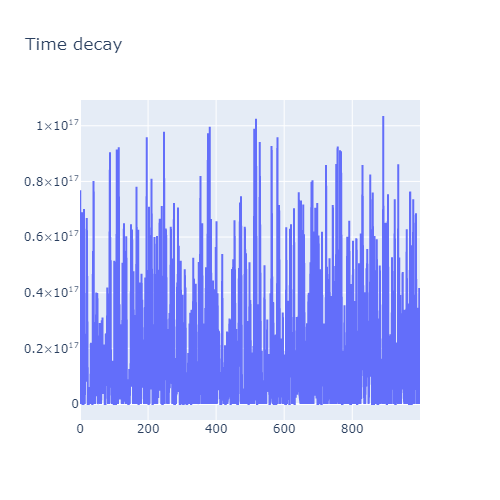

In [37]:
#plot LTV histogram
import plotly.io as pio
png_renderer = pio.renderers["png"]
png_renderer.width = 500
png_renderer.height = 500

pio.renderers.default = "png"

###
plot_data = [
    go.Scatter(
        y= td_df['DaysDiff'], mode='lines'
    )
]

plot_layout = go.Layout(
        title='Time decay'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

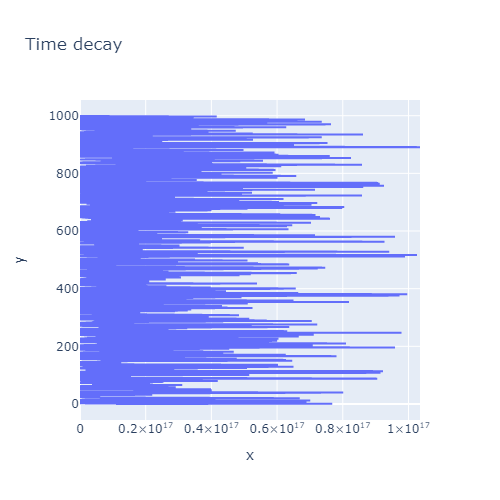

In [38]:
import plotly.io as pio
png_renderer = pio.renderers["png"]
png_renderer.width = 500
png_renderer.height = 500
pio.renderers.default = "png"
"""
import plotly.express as px

fig = px.line(test, x="Creation_Date", y="Revenue_EXVAT", color='Customer_Type')
fig.update_layout({'title_text':'Revenue per Customer Type',
'plot_bgcolor': 'rgb(256, 256, 256)',
'paper_bgcolor': 'rgb(256, 256, 256)',
'height':600,
'showlegend':True
})
fig.show()
"""

import plotly.express as px

fig = px.line(x=td_df["DaysDiff"], y=np.arange(1000), title='Time decay')
fig.show()